In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 设置数据路径
base_path = "../data/"

# 读取各个文件
orders = pd.read_csv(base_path + "olist_orders_dataset.csv", parse_dates=['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
items = pd.read_csv(base_path + "olist_order_items_dataset.csv")
payments = pd.read_csv(base_path + "olist_order_payments_dataset.csv")
reviews = pd.read_csv(base_path + "olist_order_reviews_dataset.csv")
products = pd.read_csv(base_path + "olist_products_dataset.csv")
sellers = pd.read_csv(base_path + "olist_sellers_dataset.csv")
customers = pd.read_csv(base_path + "olist_customers_dataset.csv")
geo = pd.read_csv(base_path + "olist_geolocation_dataset.csv")
cat_trans = pd.read_csv(base_path + "product_category_name_translation.csv")

# 订单延迟天数与配送天数计算
orders = orders.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date', 'order_purchase_timestamp'])
orders['delay_days'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days
orders['delay_days'] = orders['delay_days'].apply(lambda x: x if x > 0 and x <= 30 else 0)
orders['shipping_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
orders['is_delayed'] = orders['delay_days'].apply(lambda x: 1 if x > 1 else 0)


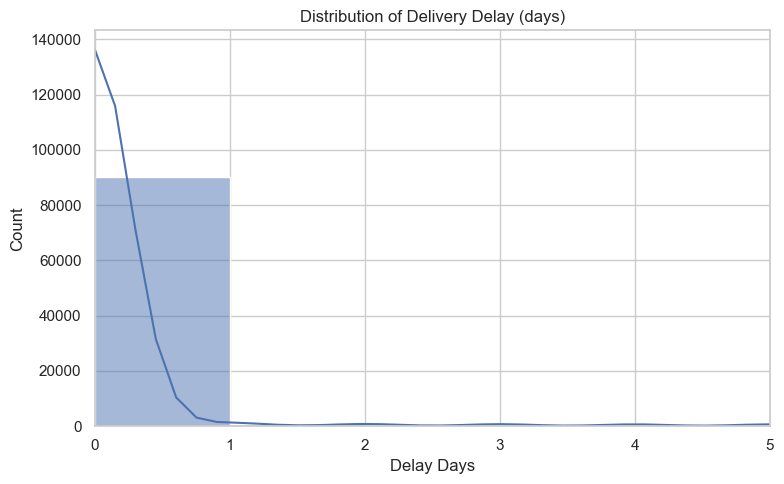

In [3]:
# 延迟分布图（缩放 0-5天）
plt.figure(figsize=(8, 5))
sns.histplot(orders['delay_days'], bins=30, kde=True)
plt.xlim(0, 5)
plt.title("Distribution of Delivery Delay (days)")
plt.xlabel("Delay Days")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

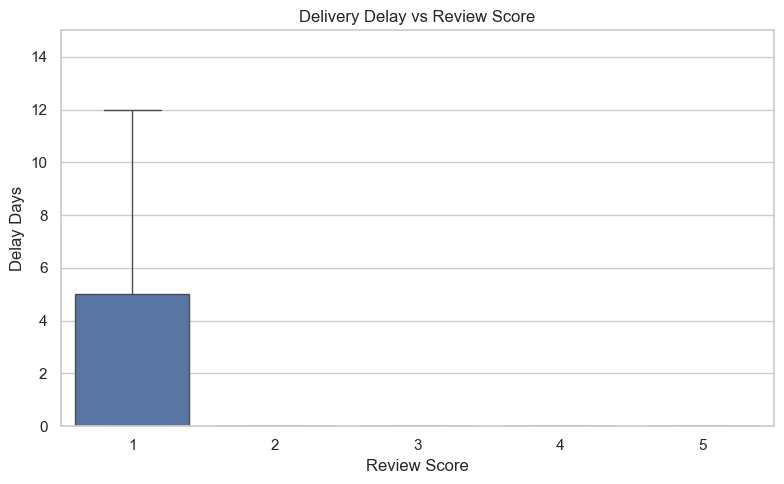

In [8]:
# Review Score 与 Delay 关系（箱线图）
order_reviews = orders.merge(reviews[['order_id', 'review_score']], on='order_id')
plt.figure(figsize=(8, 5))
sns.boxplot(x='review_score', y='delay_days', data=order_reviews, showfliers=False)
plt.title("Delivery Delay vs Review Score")
plt.xlabel("Review Score")
plt.ylabel("Delay Days")
plt.ylim(0, 15)
plt.tight_layout()
plt.show()

/var/folders/pl/2h31dnhx49s3vqnb89w_bk580000gn/T/ipykernel_35380/2374336547.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_delay.values, y=state_delay.index, palette="Reds_r")


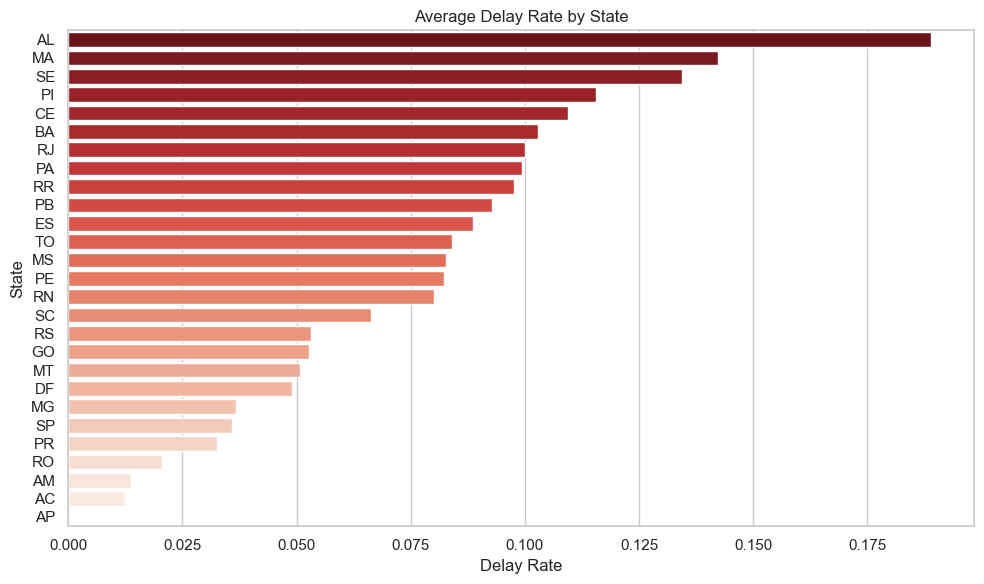

In [11]:
# 每个地区延迟率分布
order_geo = orders.merge(customers[['customer_id', 'customer_state']], on='customer_id')
state_delay = order_geo.groupby('customer_state')['is_delayed'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=state_delay.values, y=state_delay.index, palette="Reds_r")
plt.title("Average Delay Rate by State")
plt.xlabel("Delay Rate")
plt.ylabel("State")
plt.tight_layout()
plt.show()

/var/folders/pl/2h31dnhx49s3vqnb89w_bk580000gn/T/ipykernel_35380/2039857784.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_delay_df, x='is_delayed', y='product_category_name_english', palette="coolwarm")


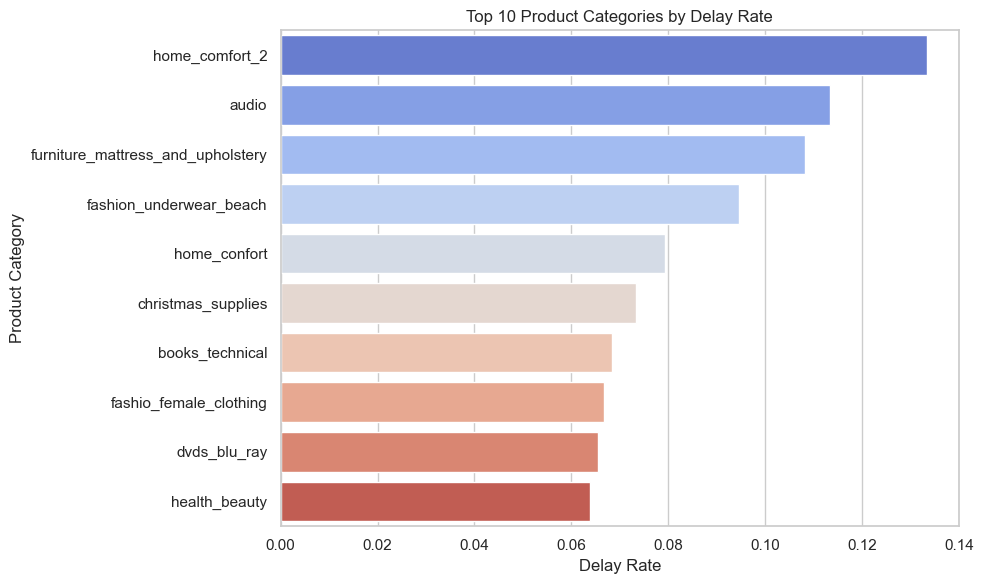

In [31]:
cat_delay_df = order_items.groupby('product_category_name_english')['is_delayed'].mean() \
    .sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=cat_delay_df, x='is_delayed', y='product_category_name_english', palette="coolwarm")
plt.title("Top 10 Product Categories by Delay Rate")
plt.xlabel("Delay Rate")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


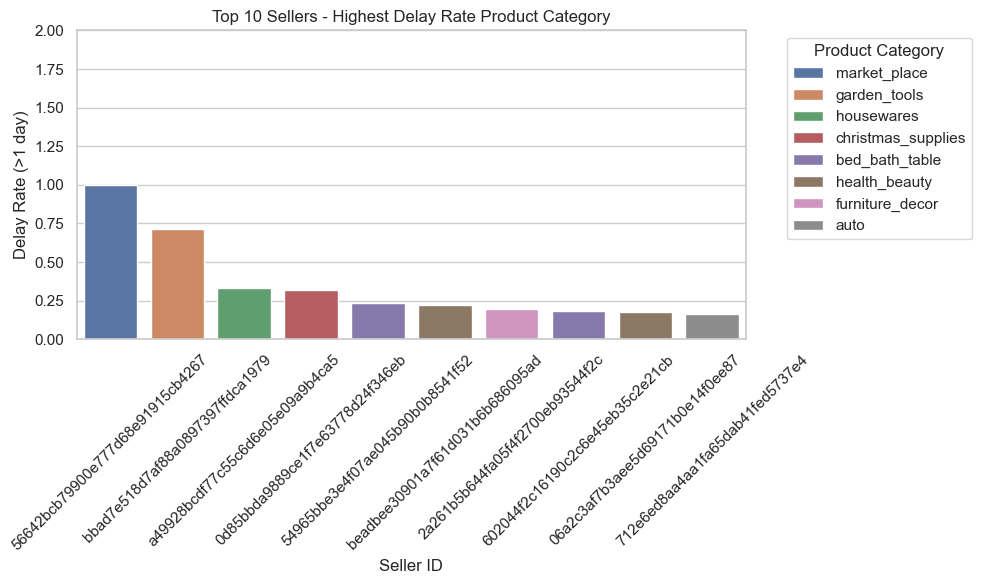

In [34]:
# —— 1. 构造 order_items & 合并翻译 —— 
order_items = items.copy()
order_items = order_items.merge(
    products[['product_id','product_category_name']],
    on='product_id', how='left'
)
order_items = order_items.merge(
    cat_trans,  # product_category_name → product_category_name_english
    on='product_category_name', how='left'
)
order_items = (
    order_items
      .merge(orders[['order_id','is_delayed']], on='order_id', how='left')
      .dropna(subset=['product_category_name_english','is_delayed'])
)

# —— 2. 先按 seller 级别算延误率 & 订单数 —— 
seller_stats = (
    order_items
      .groupby('seller_id')['is_delayed']
      .agg(delay_rate='mean', order_count='count')
      .reset_index()
)

# —— 3. 筛掉订单量过少的卖家（至少 50 单） & 取 Top10 —— 
top_seller_ids = (
    seller_stats[seller_stats['order_count'] > 50]
      .sort_values('delay_rate', ascending=False)
      .head(10)['seller_id']
      .tolist()
)

# —— 4. 拿这 10 个 seller 的明细，按 (seller,品类) 再算一次延误率 —— 
seller_cat_delay = (
    order_items[order_items['seller_id'].isin(top_seller_ids)]
      .groupby(['seller_id','product_category_name_english'])
      .agg(delay_rate=('is_delayed','mean'),
           order_count=('is_delayed','count'))
      .reset_index()
)

# —— 5. 每个 seller 选「延误率最高」的品类 —— 
top_delay_main_cat = (
    seller_cat_delay
      .sort_values(['seller_id','delay_rate'], ascending=[True,False])
      .drop_duplicates('seller_id')    # 保留每个 seller 延误率最高的一行
      .sort_values('delay_rate', ascending=False)  # 按延误率再排序一次
)

# —— 6. 画图 —— 
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_delay_main_cat,
    x='seller_id',
    y='delay_rate',
    hue='product_category_name_english',
    dodge=False
)
plt.title("Top 10 Sellers - Highest Delay Rate Product Category")
plt.xlabel("Seller ID")
plt.ylabel("Delay Rate (>1 day)")
plt.xticks(rotation=45)
plt.ylim(0,2)
plt.legend(title="Product Category", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


In [37]:
# 1) 先算每个(seller,品类)的延误率 & 订单数
seller_cat_delay = (
    order_items
      .groupby(['seller_id','product_category_name_english'])
      .agg(delay_rate=('is_delayed','mean'),
           order_count=('is_delayed','count'))
      .reset_index()
)

# 2) 剔除低量卖家，比如至少 50 单
seller_cat_delay = seller_cat_delay[seller_cat_delay['order_count'] > 50]

# 3) 为每个 seller 选延误率最高的品类
top_delay_main_cat = (
    seller_cat_delay
      .sort_values(['seller_id','delay_rate'], ascending=[True, False])
      .drop_duplicates('seller_id')
      .sort_values('delay_rate', ascending=False)
      .head(10)
)

# 4) 展示或画图，就能得到旧版那样的分布了
from IPython.display import display
display(
    top_delay_main_cat[
        ['seller_id', 'product_category_name_english', 'delay_rate', 'order_count']
    ].head(10)
)

,seller_id,product_category_name_english,delay_rate,order_count
2064,54965bbe3e4f07ae045b90b0b8541f52,bed_bath_table,0.234568,81
4567,beadbee30901a7f61d031b6b686095ad,health_beauty,0.224138,58
997,2a261b5b644fa05f4f2700eb93544f2c,furniture_decor,0.195122,82
2354,602044f2c16190c2c6e45eb35c2e21cb,bed_bath_table,0.181818,55
4046,a49928bcdf77c55c6d6e05e09a9b4ca5,toys,0.177778,90
150,06a2c3af7b3aee5d69171b0e14f0ee87,health_beauty,0.176617,402
2754,712e6ed8aa4aa1fa65dab41fed5737e4,auto,0.164706,85
1717,4869f7a5dfa277a7dca6462dcf3b52b2,audio,0.160714,56
1100,2e90cb1677d35cfe24eef47d441b7c87,electronics,0.151163,86
1773,4a3ca9315b744ce9f8e9374361493884,toys,0.148148,54


/var/folders/pl/2h31dnhx49s3vqnb89w_bk580000gn/T/ipykernel_35380/1209674991.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


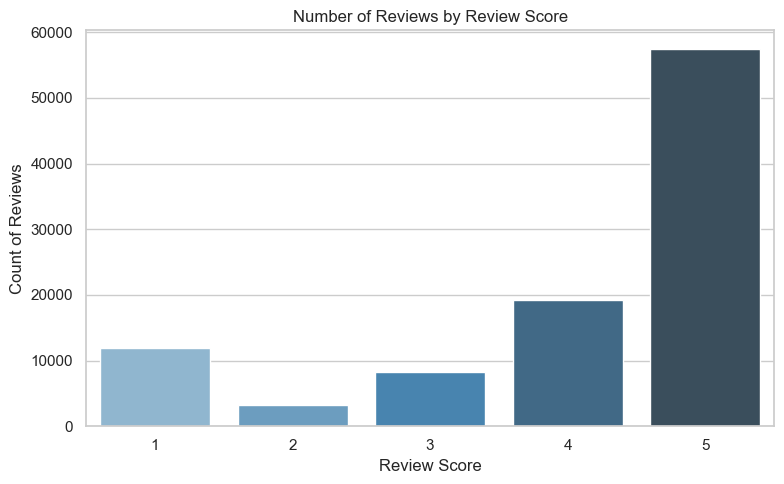

In [38]:
# —— 统计每个评分的评论数量 —— 
# 直接对 reviews 表做 value_counts
review_counts = (
    reviews['review_score']
      .value_counts()               # 统计各分值的数目
      .sort_index()                 # 按评分从小到大排序
      .reset_index()                # 转成 DataFrame
)
review_counts.columns = ['review_score', 'count']

# —— 绘图 —— 
plt.figure(figsize=(8, 5))
sns.barplot(
    x='review_score',
    y='count',
    data=review_counts,
    palette='Blues_d'              # 你也可以换其它调色板
)
plt.title("Number of Reviews by Review Score")
plt.xlabel("Review Score")
plt.ylabel("Count of Reviews")
plt.tight_layout()
plt.show()


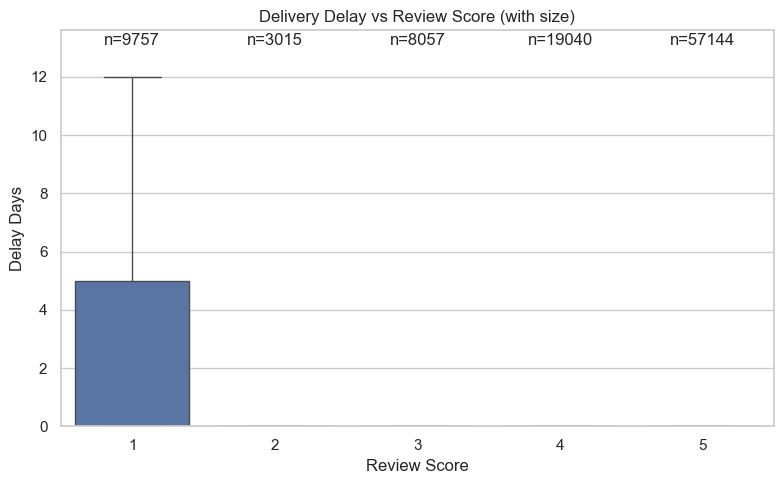

In [41]:
# —— 计算每个评分的样本量 —— 
# 如果你箱线图用的是 order_full，那么这里也用它；如果用的是 order_reviews，改成它就行
counts = order_reviews['review_score'].value_counts().sort_index()

# —— 绘图并标注 n —— 
plt.figure(figsize=(8,5))
ax = sns.boxplot(
    x='review_score',
    y='delay_days',
    data=order_reviews,
    showfliers=False
)

# 在每个箱线上方添加样本量
y_max = ax.get_ylim()[1]
for i, score in enumerate(counts.index):
    ax.text(
        i,                # x 位置：第 i 个箱子
        y_max + 0.4,      # y 位置：在最大值之上稍微偏一点
        f"n={counts[score]}",
        ha='center',      # 水平居中
        va='bottom'       # 垂直从下往上开始画文本
    )

# 扩大 ylim，以免文字被裁掉
ax.set_ylim(0, y_max + 1)

plt.title("Delivery Delay vs Review Score (with size)")
plt.xlabel("Review Score")
plt.ylabel("Delay Days")
plt.tight_layout()
plt.show()


In [49]:
import re
# —— 只保留 1 分且评论不为空 —— 
rev1 = reviews[
    (reviews['review_score'] == 1) &
    (reviews['review_comment_message'].notna())
].copy()

total = len(rev1)
print(f"1 分且有评论的总条数：{total} 条")

# —— 葡语“延迟”关键词正则 （可根据需要增删） —— 
pattern_pt = r"\b(?:atraso(?:s)?|atrasad[oa]?|demora(?:s)?|demorado(?:s)?|espera(?:s|ndo)?)\b"

# —— 匹配并计算 —— 
mask = rev1['review_comment_message'] \
    .str.contains(pattern_pt, case=False, regex=True)
count = mask.sum()

print(f"包含延迟相关关键词的：{count} 条")  
print(f"占比：{count/total:.2%}")


1 分且有评论的总条数：9179 条
包含延迟相关关键词的：553 条
占比：6.02%


In [50]:
import re
from unidecode import unidecode

# 1）预处理：去重音、全小写
rev1['msg_norm'] = (
    rev1['review_comment_message']
      .str.lower()
      .map(lambda s: unidecode(s))  # 把 á→a, ç→c 等去掉重音
)

# 2）扩展正则
pattern_pt2 = (
    r"(?:\batras(?:o|os|a|adas|ados)?\b|"    # atraso, atrasos, atrasada…
    r"\bdemor(?:a|as|ado|ados)?\b|"         # demora, demoras, demorado…
    r"\besper(?:a|as|ando)?\b|"             # espera, esperando…
    r"chegou\starde|"                       # chegou tarde
    r"nao\schegou|"                         # nao chegou
    r"entrega\satras(?:a|o)?|"              # entrega atrasada, entrega atraso
    r"fora\sdo\sprazo"                      # fora do prazo
    r")"
)

mask2 = rev1['msg_norm'].str.contains(pattern_pt2, flags=re.IGNORECASE, regex=True, na=False)
hits2 = mask2.sum()
total = len(rev1)

print(f"改进后命中：{hits2} / {total} 条，{hits2/total:.2%}")


改进后命中：1016 / 9179 条，11.07%


/var/folders/pl/2h31dnhx49s3vqnb89w_bk580000gn/T/ipykernel_35380/2666869938.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=interval_counts.index, y=interval_counts.values, palette='Blues_d')


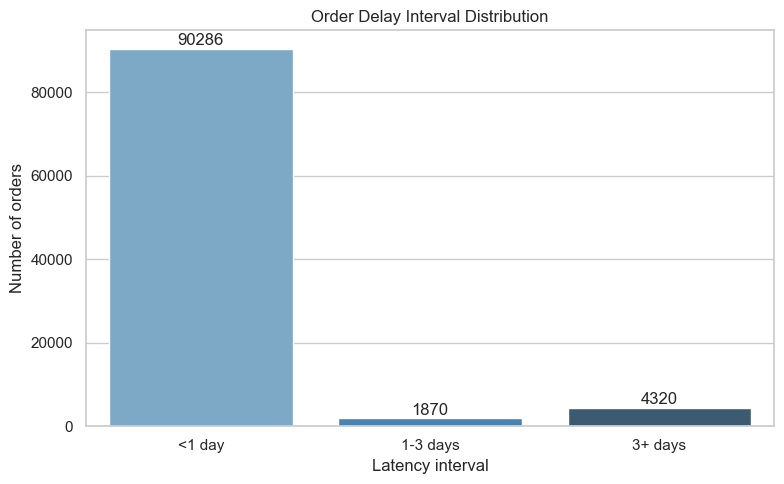

In [58]:
# —— 统计延迟区间分布并在柱子上标注数量 —— 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 orders 已经包含了 delay_days 列
bins = [-1, 0, 3, orders['delay_days'].max()]
labels = ['<1 day', '1-3 days', '3+ days']
orders['delay_interval'] = pd.cut(orders['delay_days'], bins=bins, labels=labels)

# 统计每个区间的订单数量（按顺序）
interval_counts = orders['delay_interval'].value_counts().reindex(labels)

# 绘制柱状图
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=interval_counts.index, y=interval_counts.values, palette='Blues_d')
plt.title("Order Delay Interval Distribution")
plt.xlabel("Latency interval")
plt.ylabel("Number of orders")

# 在每个柱子顶部添加数量标签
max_count = interval_counts.max()
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,      # x 坐标：柱子中间
        p.get_height() + max_count*0.01,    # y 坐标：柱子高度上方一点
        int(p.get_height()),                # 文本内容：数量
        ha='center'                         # 水平居中
    )

plt.tight_layout()
plt.show()


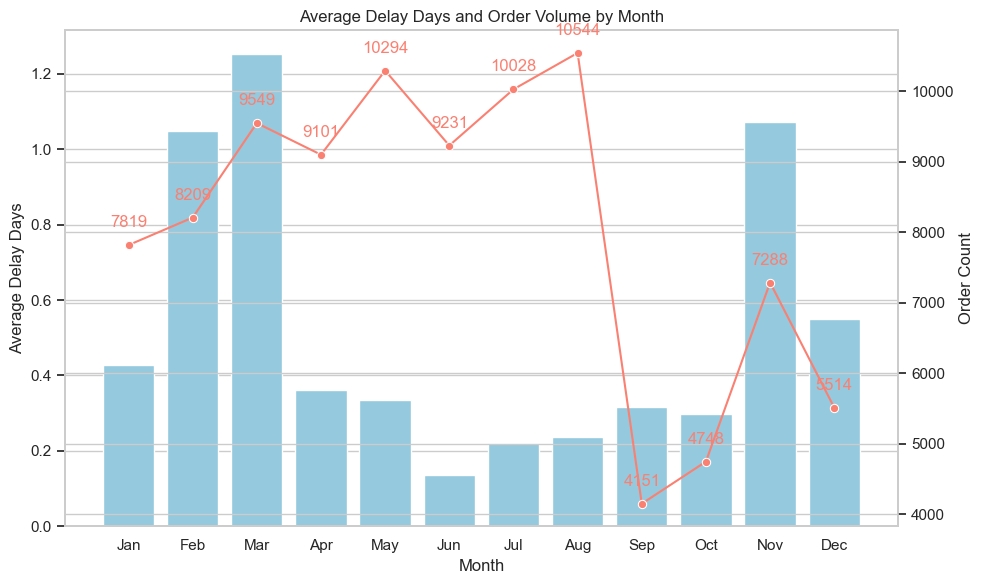

In [59]:
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

# —— 1) 按月统计平均延迟天数 & 订单量 —— 
orders['month'] = orders['order_purchase_timestamp'].dt.month
monthly = (
    orders
      .groupby('month')
      .agg(
          avg_delay=('delay_days','mean'),
          order_count=('order_id','count')
      )
      .reindex(range(1,13), fill_value=0)
      .reset_index()
)
monthly['month_name'] = monthly['month'].apply(lambda m: calendar.month_abbr[m])

# —— 2) 绘制双轴图：柱状（平均延迟）+ 折线（订单量） —— 
fig, ax1 = plt.subplots(figsize=(10, 6))

# 平均延迟 天数（柱状）
sns.barplot(
    x='month_name', 
    y='avg_delay', 
    data=monthly, 
    ax=ax1, 
    color='skyblue'
)
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Delay Days')
ax1.set_title('Average Delay Days and Order Volume by Month')

# 订单量（折线）
ax2 = ax1.twinx()
sns.lineplot(
    x='month_name', 
    y='order_count', 
    data=monthly, 
    marker='o', 
    ax=ax2, 
    color='salmon'
)
ax2.set_ylabel('Order Count')

# —— 3) 标注折线上的订单量 —— 
for x, y in zip(ax2.get_xticks(), monthly['order_count']):
    ax2.text(
        x, 
        y + monthly['order_count'].max() * 0.02, 
        int(y), 
        ha='center', 
        va='bottom', 
        color='salmon'
    )

plt.tight_layout()
plt.show()
